In [1]:
import pandas as pd

# Load datasets
file_paths = {
    "League": "League.csv",
    "Teams1": "Teams1.csv",
    "Teams2": "Teams2.csv",
    "Matches": "Matches.csv",
    "Players": "Players.csv",
}

datasets = {name: pd.read_csv(path) for name, path in file_paths.items()}

# Extract offensive players (forwards and midfielders)
players_df = datasets["Players"]
offensive_players_df = players_df[players_df['position'].isin(['Forward', 'Midfielder'])]

# Display dataset overview
print("Players Dataset Shape:", players_df.shape)
print("Offensive Players Dataset Shape:", offensive_players_df.shape)


Players Dataset Shape: (570, 277)
Offensive Players Dataset Shape: (324, 277)


In [3]:
# Check for missing values in the offensive players dataset
print("Missing Values in Offensive Players Dataset:")
missing_values = offensive_players_df.isnull().sum()
print(missing_values[missing_values > 0])  # Display columns with missing values only


Missing Values in Offensive Players Dataset:
average_rating_overall                         324
assists_per_game_overall                       324
sm_assists_total_overall                       324
assists_per90_percentile_overall               324
passes_per_90_overall                          324
                                              ... 
booked_over05_percentage_overall               324
booked_over05_percentage_percentile_overall    324
shirt_number                                   324
annual_salary_gbp                              324
annual_salary_usd                              324
Length: 230, dtype: int64


In [4]:
# Select relevant columns for analysis
relevant_columns = ['goals_overall', 'assists_overall', 'shots_per_90_overall', 'xg_per_game_overall']
offensive_players_filtered = offensive_players_df[relevant_columns]


In [5]:
# Check missing values in the filtered dataset
print("Missing Values in Filtered Dataset:")
print(offensive_players_filtered.isnull().sum())


Missing Values in Filtered Dataset:
goals_overall             0
assists_overall           0
shots_per_90_overall    324
xg_per_game_overall     324
dtype: int64


In [6]:
# Fill missing values with zeros for simplicity (customize as needed)
offensive_players_filtered = offensive_players_filtered.fillna(0)

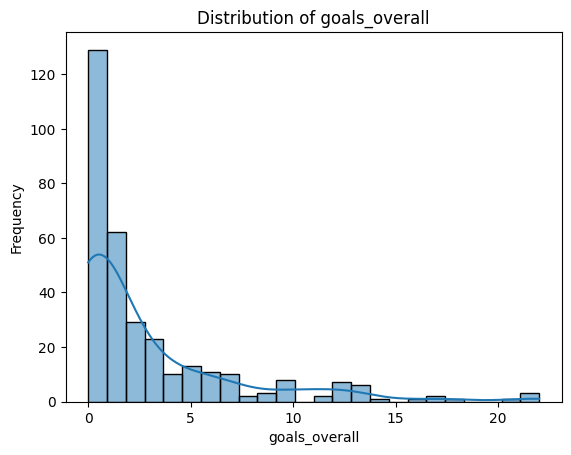

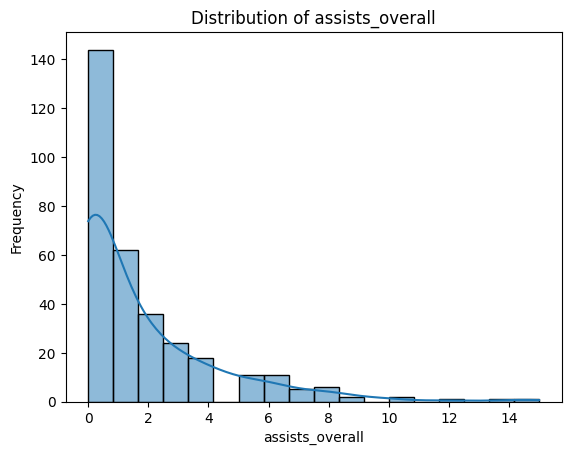

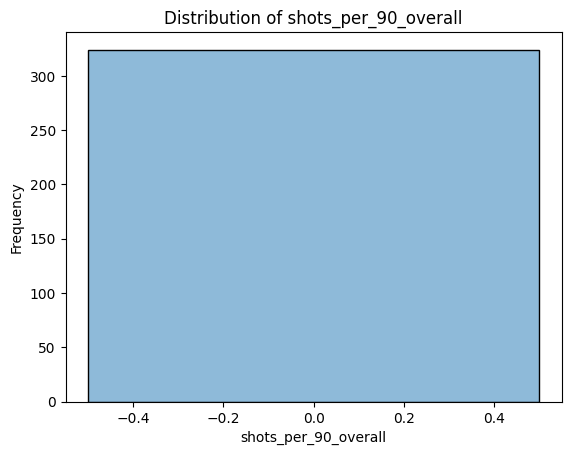

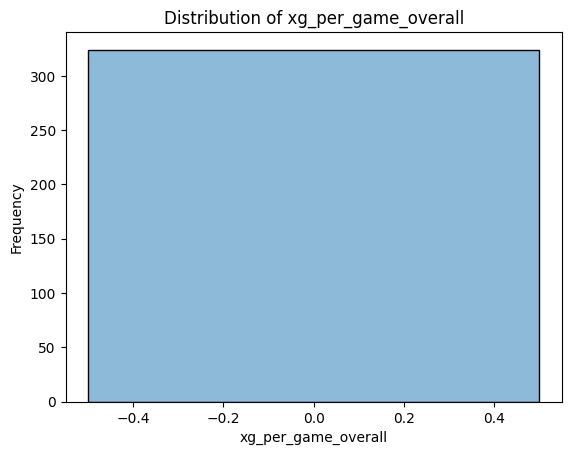

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize the distribution of key variables
key_variables = ['goals_overall', 'assists_overall', 'shots_per_90_overall', 'xg_per_game_overall']

for var in key_variables:
    sns.histplot(offensive_players_filtered[var], kde=True)
    plt.title(f"Distribution of {var}")
    plt.xlabel(var)
    plt.ylabel("Frequency")
    plt.show()


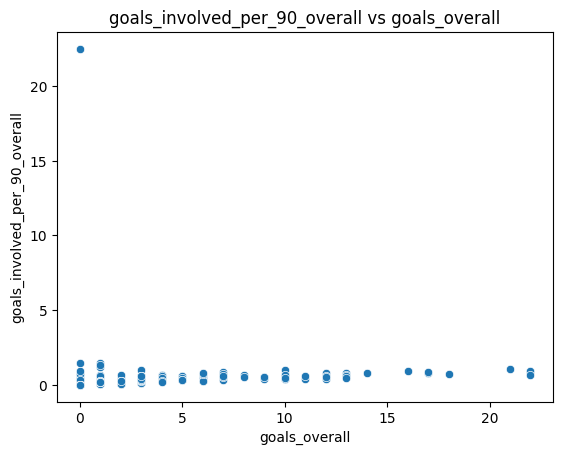

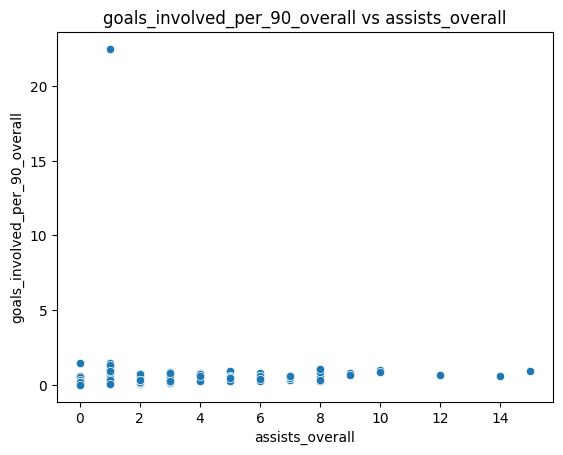

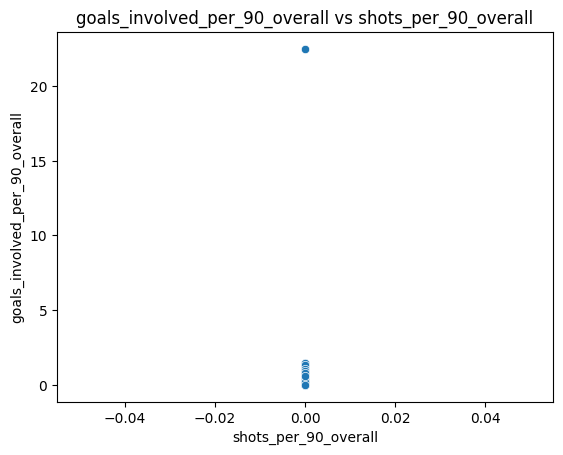

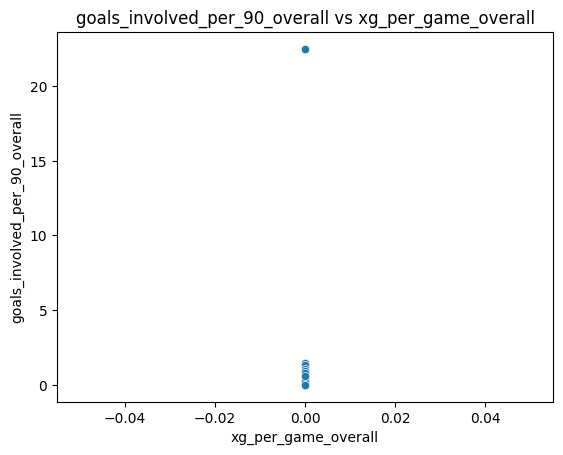

In [8]:
# Define the performance metric
performance_metric = 'goals_involved_per_90_overall'

# Ensure the performance metric is included in the dataset
offensive_players_filtered[performance_metric] = offensive_players_df[performance_metric]

# Plot relationships between the performance metric and each key variable
key_variables = ['goals_overall', 'assists_overall', 'shots_per_90_overall', 'xg_per_game_overall']

for var in key_variables:
    sns.scatterplot(x=offensive_players_filtered[var], y=offensive_players_filtered[performance_metric])
    plt.title(f"{performance_metric} vs {var}")
    plt.xlabel(var)
    plt.ylabel(performance_metric)
    plt.show()


In [9]:
from scipy.stats import spearmanr

# Linear correlation using Pearson
linear_corr = offensive_players_filtered.corr()[performance_metric].sort_values(ascending=False)
print("Linear Correlation (Pearson) with Performance Metric:")
print(linear_corr)

# Non-linear correlation using Spearman
print("\nNon-Linear Correlation (Spearman):")
for var in key_variables:
    correlation, _ = spearmanr(offensive_players_filtered[var], offensive_players_filtered[performance_metric])
    print(f"Spearman Correlation ({var} vs {performance_metric}): {correlation}")


Linear Correlation (Pearson) with Performance Metric:
goals_involved_per_90_overall    1.000000
assists_overall                  0.111691
goals_overall                    0.106829
shots_per_90_overall                  NaN
xg_per_game_overall                   NaN
Name: goals_involved_per_90_overall, dtype: float64

Non-Linear Correlation (Spearman):
Spearman Correlation (goals_overall vs goals_involved_per_90_overall): 0.8081956057999549
Spearman Correlation (assists_overall vs goals_involved_per_90_overall): 0.7404982933955625
Spearman Correlation (shots_per_90_overall vs goals_involved_per_90_overall): nan
Spearman Correlation (xg_per_game_overall vs goals_involved_per_90_overall): nan


C:\Users\rahul\AppData\Local\Temp\ipykernel_39548\2686651530.py:11: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, _ = spearmanr(offensive_players_filtered[var], offensive_players_filtered[performance_metric])


In [22]:
import pymc3 as pm
import numpy as np

# Prepare the data for modeling
key_predictors = ['goals_overall', 'assists_overall', 'shots_per_90_overall', 'xg_per_game_overall']  # Use strongest predictors
X = offensive_players_filtered[key_predictors].fillna(0).values
y = offensive_players_filtered['goals_involved_per_90_overall'].fillna(0).values

# Standardize predictors for better model performance
X_mean = np.mean(X, axis=0)
X_std = np.std(X, axis=0)
X_standardized = (X - X_mean) / X_std

# Bayesian model
with pm.Model() as model:
    # Priors for coefficients and intercept
    intercept = pm.Normal('Intercept', mu=0, sigma=1)
    coefficients = pm.Normal('Coefficients', mu=0, sigma=1, shape=X_standardized.shape[1])
    
    # Linear combination of predictors
    mu = intercept + pm.math.dot(X_standardized, coefficients)
    
    # Prior for error term
    sigma = pm.HalfNormal('Sigma', sigma=1)
    
    # Likelihood (observed data)
    likelihood = pm.Normal('Likelihood', mu=mu, sigma=sigma, observed=y)
    
    # Sampling from the posterior
    trace = pm.sample(1000, return_inferencedata=True)

# Plot trace for posterior distributions
pm.plot_trace(trace)
plt.show()


ModuleNotFoundError: No module named 'pymc3'

In [ ]:
# Posterior predictive checks
with model:
    # Generate posterior predictive samples
    ppc = pm.sample_posterior_predictive(trace, var_names=["Likelihood"])

# Trace plots to check parameter convergence
pm.plot_trace(trace)
plt.show()

# Posterior predictive distribution
predicted_values = ppc['Likelihood'].mean(axis=0)  # Mean predictions from posterior samples
plt.figure(figsize=(8, 5))
plt.scatter(y, predicted_values, alpha=0.6)
plt.plot([min(y), max(y)], [min(y), max(y)], color='red', linestyle='--')
plt.xlabel("Observed Values")
plt.ylabel("Predicted Values")
plt.title("Posterior Predictive Check: Observed vs. Predicted")
plt.show()

# Histogram of residuals
residuals = y - predicted_values
sns.histplot(residuals, kde=True)
plt.title("Residuals Distribution")
plt.xlabel("Residuals (Observed - Predicted)")
plt.ylabel("Frequency")
plt.show()


In [23]:
# Summary of the posterior distribution for coefficients
coeff_summary = pm.summary(trace, var_names=["Intercept", "Coefficients"])
print("Posterior Summary for Model Parameters:")
print(coeff_summary)

# Visualize the coefficients
coeff_names = ["Intercept"] + key_predictors
coeff_means = [trace.posterior["Intercept"].mean().item()] + [
    trace.posterior["Coefficients"][:, i].mean().item() for i in range(len(key_predictors))
]

plt.figure(figsize=(8, 5))
plt.barh(coeff_names, coeff_means, color='skyblue')
plt.title("Posterior Mean of Coefficients")
plt.xlabel("Coefficient Value")
plt.ylabel("Predictors")
plt.axvline(0, color='red', linestyle='--')
plt.show()

# Insights from PPC and residuals
print("\nInsights:")
print("1. Predictors with larger absolute coefficient values have the strongest influence on the performance metric.")
print("2. Check the residuals: If they are centered around zero with no clear pattern, the model is a good fit.")
print("3. Evaluate the scatterplot of observed vs. predicted values. A tighter fit along the diagonal indicates better predictive accuracy.")


NameError: name 'pm' is not defined